In [11]:
import numpy as np
from datetime import *
import requests as Req
from lxml import etree
from typing import List
from os import *

#根据基金代码到 天天基金网拉取数据
# http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&code=020003&page=10&per=20&sdate=2016-10-01&edate=2017-10-01
#lsjz 历史净值
#code 基金代码
#sdate 开始时间 格式:2016-10-01 
#edate 结束时间 格式:2017-10-01
#per 每页多少条
#page 第几页
#返回 [(日期,净值,增长率)]


def load_raw_data(code: str, sdate: date = None, edate: date = None) -> str:
    if edate is None:
        edate = datetime.now().date()

    if sdate is None:
        sdate = date(edate.year - 3, edate.month, edate.day)

    print(code, sdate, edate)

    url: str = f"http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&code={code}&page=1&per=3000&sdate={sdate}&edate={edate}"
    print("开始加载数据", url)

    resp: Req.Response = Req.get(url, headers={
        "user-agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36",
        "Accept-Encoding": "gzip, deflate",
        "Accept-Language": "zh-CN,zh;q=0.8,en-US;q=0.6,en;q=0.4"})

    result_str: str = resp.content.decode("utf-8")
    #    print(result_str)
    #    print(result_str.index("<table"), result_str.index("table>"))
    data_str: str = result_str[result_str.index("<table"):result_str.index("table>") + len("table>")]
    #print(data_str)
    return data_str


def _if(flag: bool, a, b):
    if flag:
        return a
    return b


def try_float(s: str, _default: float = 0.0)-> float:
    try:
        return float(s)
    except ValueError:
        return _default


def parse_raw_data(data_str: str)-> np.ndarray:
    el: etree._Element = etree.HTML(data_str)
    trList: List[etree._Element] = el.xpath("//tbody/tr")
    data: np.ndarray = np.array([[td for td in tr.xpath("./td/text()")[:4]] for tr in trList])
    data = np.array(
        [[datetime.strptime(row[0], '%Y-%m-%d'), try_float(row[1]), try_float(row[2]), try_float(row[3][:-1])] for row
         in data])
    data = data[::-1]
    return data


def get_fund_data(code: str, sdate: date = None, edate: date = None)-> np.ndarray:
    folder_path: str = f"c:\\temp\\fund"
    if not path.exists(folder_path):
        mkdir(folder_path)

    file_path: str = f"c:\\temp\\fund\\{code}.csv"
    if not path.exists(file_path):
        print(f"found no data file at:\n\t{file_path}")
        now: date = datetime.now()
        start: date = date(now.year - 5, now.month, now.day)
        loaded: np.ndarray = parse_raw_data(load_raw_data(code, start))
        print(loaded[0:3])
        loaded = np.array([np.append([row[0].strftime("%Y-%m-%d")], row[1:]) for row in loaded])
        print(loaded[0:3])
        np.savetxt(file_path, loaded, delimiter=",", fmt=["%s", "%.4f", "%.4f", "%.4f"])
        print(f"load and save data to:\n\t{file_path}")

    if edate is None:
        edate = datetime.now().date()

    if sdate is None:
        sdate = date(edate.year - 3, edate.month, edate.day)

    start: str = sdate.strftime("%Y-%m-%d")
    end: str = edate.strftime("%Y-%m-%d")

    data: np.ndarray = np.loadtxt(file_path, delimiter=",", dtype={
        "names": ("date", "price", "value", "change"),
        "formats": ("S10", "f", "f", "f")})
    data_in_span: np.array = np.array([list(row) for row in data if start <= str(row[0].decode('utf-8')) <= end])
    data = np.array(
        [np.append(np.array(datetime.strptime(row[0].decode('utf-8'), "%Y-%m-%d")), [float(fv) for fv in row[1:]]) for
         row in data_in_span])
    return data


_data: np.ndarray = get_fund_data("161725", sdate=date(2016, 10, 1))
print(_data[-1])


[datetime.datetime(2017, 9, 29, 0, 0) 1.012 1.543 -0.98]


初步结论:
观察了若干基金一年内的波动情况,模拟了3种简单的定投方式
结论是,对于上涨趋势的基金,固定金额的定投就好
止损或者止盈反而减少收益

对于下跌较多的基金
止损比较有意义

总投入 = 24500	最终余额 = [39704.91910950135]	增长率 = [62.06089432449532]%	一次性投24500	
总投入 = 24500	最终余额 = [28533.646422800386]	增长率 = [16.46386295020566]%	一次性投24500	


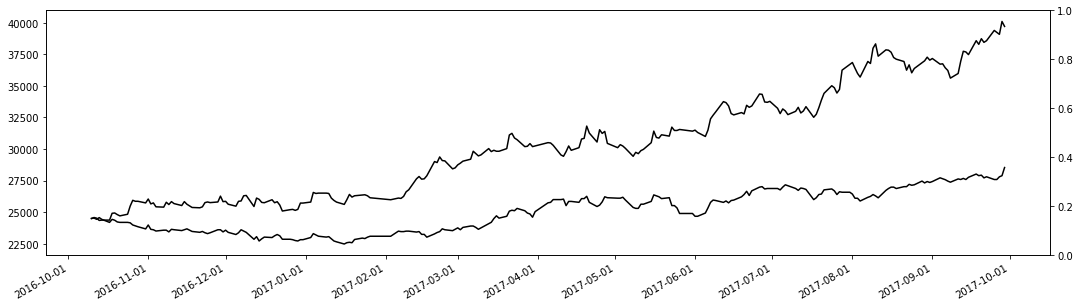

In [4]:
#sdate 开始日期,设置为空, 默认为现在时间的三年前
#edate 结束日期, 默认为现在时间
"""
国泰金龙行业精选(020003)
上投摩根行业轮动混合A(377530)  
金鹰核心资源混合(210009)
易方达上证50指数A(110003)
建信中证500指数增强(000478)
国泰纳斯达克100指数(160213)
招商中证白酒指数分级(161725)
广发全球精选股票(QDII)(270023)
上投摩根核心成长(000457)
嘉实全球互联网股票人民币(000988)
摩根太平洋证券人民币 968010
嘉实沪港深精选股票(001878)
鹏华创业板分级(160637)
中邮创新优势灵活配置混合(001275)
长信量化先锋混合A(519983)
汇添富移动互联股票(000697)
博时黄金ETF(159937) 
"""
sdate: date = date(2016, 10, 1)
data0: np.ndarray = get_fund_data("161725", sdate=sdate)
xd: np.ndarray = np.array([_date[0] for _date in data0[0:len(data0), 0:1]])
days_count: int = len(data0)
datas: np.ndarray = np.array([data0,
                            get_fund_data("020003", sdate=sdate),
                            get_fund_data("377530", sdate=sdate),
                            get_fund_data("000457", sdate=sdate),
                            get_fund_data("000478", sdate=sdate),
                            get_fund_data("161725", sdate=sdate),
                            get_fund_data("110003", sdate=sdate)])

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# import pylab as plt
from matplotlib.lines import Line2D
import matplotlib.axes as _ax
import matplotlib.figure as _fig
from matplotlib.axis import XAxis

#data = data[:10]
# 生成横纵坐标信息
value_yd: np.ndarray = np.array([data0[i][2] for i in range(0, len(xd))])
changes_span = data0[0:days_count, 3:4]

fig: _fig.Figure = None
ax: _ax.Axes = None

fig, ax1 = plt.subplots()
#设置图片大小
fig.set_size_inches(18, 5)
# 配置横坐标
xax: XAxis = ax1.xaxis
xax.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
xax.set_major_locator(mdates.MonthLocator())
# xax.set_minor_locator(mdates.DateLocator())
# ax.set_xlabel("日期")
# ax.set_ylabel("投资/结余")
ax2: _ax.Axes = ax1.twinx()

days_count: int = len(data0)
# 绘制基金净值
# for data in datas[:6]:
#     value_plt: Line2D = ax1.plot(xd, data[0:days_count, 2:3], "k-")

# 
def invest_once(changes: List[float], invest: float = 1.0)-> List[float]:
    balances: List[float] = [invest]
    for i in range(1, len(changes)):
        balances.append(balances[-1] * (100 + changes[i]) / 100)
    final: float = balances[-1]
    print(f"总投入 = {invest}\t最终余额 = {final}\t增长率 = {(final - invest) / invest * 100}%\t一次性投{invest}\t")
    return balances
# 
# 
# once_plt: Line2D = ax2.plot(xd, invest_once(changes_span, 100 * days_count), "g")
for data in datas[:2]:
    value_plt: Line2D = ax1.plot(xd, invest_once(data[0:days_count, 3:4], 100 * days_count), "k-")
# 
# 
# def static_plan(changes: List[float], invest: float = 100)-> List[float]:
#     balances: List[float] = [invest]
#     invest_sum: float = invest
#     for i, change in enumerate(changes[1:]):
#         invest_sum += invest
#         balances.append(invest + balances[-1] * (100 + change) / 100)
# 
#     final: float = balances[-1]
#     print(f"总投入 = {invest_sum}\t最终余额 = {final}\t增长率 = {(final - invest_sum) / invest_sum * 100}%\t每天投{invest}\t")
#     return balances
# 
# 
# day_100_plt: Line2D = ax2.plot(xd, static_plan(changes_span, 100), "r")
# 
# 
# def dynamic_plan_1(changes: List[float], invest: float = 100)-> List[float]:
#     balances: List[float] = [invest]
#     invest_sum: float = invest
#     final: float = 0
#     for i, change in enumerate(changes[1:]):
#         invest = balances[0]
#         if change > 0:
#             invest = 0
# 
#         if change < -1.5:
#             invest *= 1.5
#         if change < -2.5:
#             invest *= 1.5
# 
#         _xd: date = xd[i]
#         if _xd.weekday() == 3:
#             invest *= 1.5
# 
#         invest_sum += invest
#         balances.append(invest + balances[-1] * (100 + change) / 100)
# 
#     final = final + balances[-1]
#     print(f"总投入 = {invest_sum}\t最终余额 = {final}\t增长率 = {(final - invest_sum) / invest_sum * 100}%\t每天投{invest}\t")
#     return balances
# 
# 
# dynamic_plan_1_plt: Line2D = ax2.plot(xd, dynamic_plan_1(changes_span, 200), "b")

# def dynamic_plan_2(changes: List[float], invest: float = 100)-> List[float]:
#     base: float = invest
#     target: float = 1.1
#     balances: List[float] = [invest]
#     invest_sum: float = invest
#     final: float = 0
#     for i, change in enumerate(changes[1:]):
#         invest = balances[0]
# 
#         if balances[-1] / invest_sum >= target:
#             final += balances[-1] / 2
#             balances[-1] *= 0.5
#         if balances[-1] / invest_sum < 0.9:
#             invest_sum += balances[-1] / 2
#             balances[-1] *= 1.5
# 
#         invest_sum += invest
#         balances.append(invest + balances[-1] * (100 + change) / 100)
# 
#     final = final + balances[-1]
#     print(f"总投入 = {invest_sum}\t最终余额 = {final}\t增长率 = {(final - invest_sum) / invest_sum * 100}%\t每天投{invest}\t")
#     return balances
# 
# 
# dynamic_plan_2_plt: Line2D = ax2.plot(xd, dynamic_plan_2(changes_span, 200), "b")

# def cheating(changes: List[float], invest: float = 100)-> List[float]:
#     balances: List[float] = [invest]
#     invest_sum: float = invest
#     final: float = 0
#     last_increase: int = 0
#     for i, change in enumerate(changes[1:]):
#         invest = balances[0]
# 
#         if change > 0:
#             invest = 0
# 
#         if change < -1.5:
#             invest *= 2.5
#         if change < -2.5:
#             invest *= 2.5
# 
#         if i < len(changes):
#             cheat: float = changes[i + 1]
#             if cheat > 1.5:
#                 invest *= 2.5
#             if cheat > 2.5:
#                 invest *= 2.5
#             if cheat < 0:
#                 invest = 0
# 
#         invest_sum += invest
#         balances.append(invest + balances[-1] * (100 + change) / 100)
# 
#     final = final + balances[-1]
#     print(f"总投入 = {invest_sum}\t最终余额 = {final}\t增长率 = {(final - invest_sum) / invest_sum * 100}%\t每天投{invest}\t")
#     return balances
# 
# 
# cheating_plt: Line2D = ax2.plot(xd, cheating(changes_span, 200), "y")

plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.show()


In [10]:
sdate: date = date(2016, 10, 1)
data0: np.ndarray = get_fund_data("161725", sdate=sdate)
data0

array([[datetime.datetime(2016, 10, 10, 0, 0), 0.954, 0.969, 1.49],
       [datetime.datetime(2016, 10, 11, 0, 0), 0.957, 0.972, 0.31],
       [datetime.datetime(2016, 10, 12, 0, 0), 0.955, 0.97, -0.21],
       [datetime.datetime(2016, 10, 13, 0, 0), 0.948, 0.963, -0.73],
       [datetime.datetime(2016, 10, 14, 0, 0), 0.949, 0.964, 0.11],
       [datetime.datetime(2016, 10, 17, 0, 0), 0.949, 0.964, 0.0],
       [datetime.datetime(2016, 10, 18, 0, 0), 0.97, 0.985, 2.21],
       [datetime.datetime(2016, 10, 19, 0, 0), 0.971, 0.986, 0.1],
       [datetime.datetime(2016, 10, 20, 0, 0), 0.966, 0.981, -0.51],
       [datetime.datetime(2016, 10, 21, 0, 0), 0.962, 0.977, -0.41],
       [datetime.datetime(2016, 10, 24, 0, 0), 0.967, 0.982, 0.52],
       [datetime.datetime(2016, 10, 25, 0, 0), 0.992, 1.007, 2.59],
       [datetime.datetime(2016, 10, 26, 0, 0), 1.01, 1.025, 1.81],
       [datetime.datetime(2016, 10, 27, 0, 0), 1.007, 1.022, -0.3],
       [datetime.datetime(2016, 10, 28, 0, 0), 1.